In [1]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import utils

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# PPO
class PPOPolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PPOPolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))+ 0.01
        return mu, std

class PPOValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(PPOValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPOContinuous:
    ''' PPO algorithm for handling continuous actions '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PPOPolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = PPOValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        counts = torch.tensor(transition_dict['counts'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) 
        td_delta = td_target - self.critic(states)
        advantage = utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # Actions are normally distributed
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 100
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
xi = 2
c = 35
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
torch.manual_seed(0)
state_dim = 2
action_dim = 1  # Continuous action space
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

PPO_return_list = utils.train_on_policy_agent(agent,num_episodes,xi,c)

Iteration 9: 100%|█████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s, episode=100, return=291900.993]


In [3]:
# DDPG
class DDPGPolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(DDPGPolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound is the maximum action value acceptable by the environment

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class DDPGQValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(DDPGQValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # Concatenate state and action
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)
    
class DDPG:
    ''' DDPG algorithm '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = DDPGPolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = DDPGQValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = DDPGPolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = DDPGQValueNet(state_dim, hidden_dim, action_dim).to(device)
        # Initialize target value network and set its parameters to be the same as the value network
        self.target_critic.load_state_dict(self.critic.state_dict())
        # Initialize target policy network and set its parameters to be the same as the policy network
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # Standard deviation of Gaussian noise; mean is set to zero
        self.tau = tau  # Softly update target network parameters
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # Add noise to actions to increase exploration
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
#         print(transition_dict)
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        counts = torch.tensor(transition_dict['counts'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # Softly update policy network
        self.soft_update(self.critic, self.target_critic)  # Softly update value network

actor_lr = 3e-4
critic_lr = 3e-3
num_episodes =100
hidden_dim = 128
gamma = 0.98
tau = 0.005  # Softly update parameters
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # Standard deviation of Gaussian noise
xi = 2
c = 35
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = utils.ReplayBuffer(buffer_size)
state_dim = 2
action_dim = 1
action_bound = 2  # Maximum value of action
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

DDPG_return_list = utils.train_off_policy_agent(agent, num_episodes, replay_buffer, minimal_size, batch_size,xi,c)

Iteration 9: 100%|█████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it, episode=100, return=348623.302]


In [4]:
# SAC
class SACPolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(SACPolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))+0.01
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample() performs reparameterized sampling
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # Compute the log probability density of the tanh_normal distribution (first-order Taylor approximation)
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class SACQValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(SACQValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

class SACContinuous:
    ''' SAC algorithm for handling continuous actions '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = SACPolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # Policy network
        self.critic_1 = SACQValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # First Q-network
        self.critic_2 = SACQValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # Second Q-network
        self.target_critic_1 = SACQValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # First target Q-network
        self.target_critic_2 = SACQValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # Second target Q-network
        # Initialize target Q-network parameters to be the same as Q-network parameters
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # Using the log value of alpha for stability during training
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # Alpha is differentiable (gradients can be computed for alpha)
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # Target entropy value
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states):  # Compute target Q-values
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        counts = torch.tensor(transition_dict['counts'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # Update both Q-networks
        td_target = self.calc_target(rewards, next_states)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # Update policy network
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update alpha value
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

state_dim = 2
action_dim =1
action_bound = 2  # Maximum value of action
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # Softly update parameters
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -1
xi = 2
c = 35
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

SAC_return_list = utils.train_off_policy_agent(agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size,xi,c)

Iteration 9: 100%|█████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it, episode=100, return=355460.674]


In [5]:
num_episodes = 100
xi = 2
c = 35
Human_agent_return_list = utils.human_agent_2(num_episodes,xi,c)


Iteration 9: 100%|███████████████████████████████████| 10/10 [00:00<00:00, 3339.41it/s, episode=100, return=285676.797]


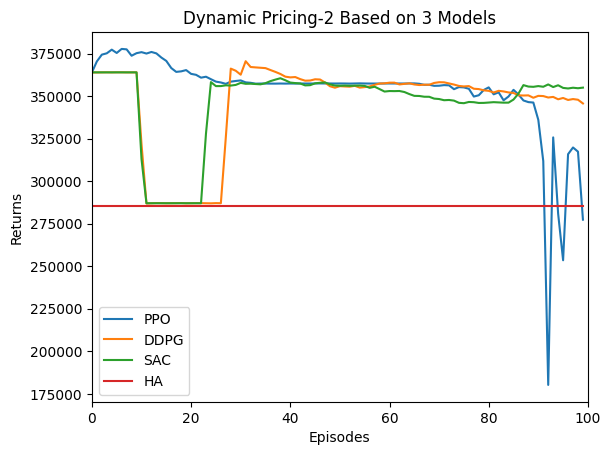

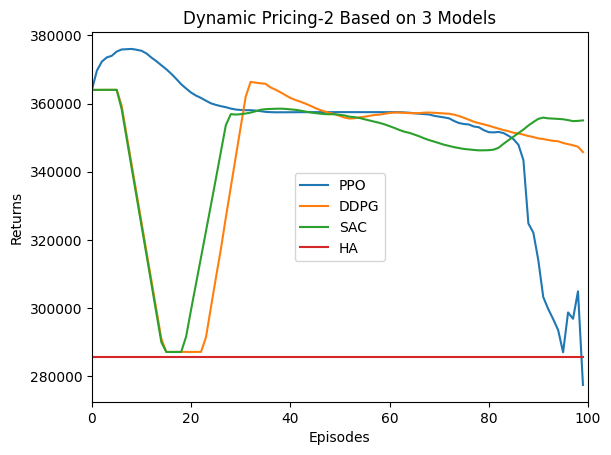

In [6]:
episodes_list = list(range(len(DDPG_return_list)))
plt.plot(episodes_list, PPO_return_list,label="PPO")
plt.plot(episodes_list, DDPG_return_list,label="DDPG")
plt.plot(episodes_list, SAC_return_list,label="SAC")
plt.plot(episodes_list, Human_agent_return_list,label="HA")
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.xlim(0,100)
# plt.ylim(1300000,1500000)
plt.title('{}Based on 3 Models'.format("Dynamic Pricing-2 "))
plt.show()


PPO_mv_return = utils.moving_average(PPO_return_list, 9)
DDPG_mv_return = utils.moving_average(DDPG_return_list, 9)
SAC_mv_return = utils.moving_average(SAC_return_list, 9)
HA_mv_return = utils.moving_average(Human_agent_return_list, 9)

plt.plot(episodes_list, PPO_mv_return,label="PPO")
plt.plot(episodes_list, DDPG_mv_return,label="DDPG")
plt.plot(episodes_list, SAC_mv_return,label="SAC")
plt.plot(episodes_list, HA_mv_return,label="HA")

plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.xlim(0,100)
# plt.ylim(1300000,1500000)
plt.title('{}Based on 3 Models'.format("Dynamic Pricing-2 "))
plt.show()

In [7]:
print(PPO_return_list)
print(DDPG_return_list)
print(SAC_return_list)
print(Human_agent_return_list)

[364031.707695323, 370483.51277476916, 374460.26638154034, 375250.5452041871, 377401.6575386334, 375450.13097707415, 377829.2496167526, 377575.30158782564, 373828.2480689368, 375327.1249604744, 375931.71702020714, 375108.6743634552, 376039.05515899236, 375201.6478045297, 372758.43501471117, 370768.22945361625, 366580.9420590816, 364322.60975755105, 364635.5174754186, 365382.13420790865, 363160.8837203817, 362596.0894564986, 360925.9869656217, 361476.7922282812, 360025.08360512607, 358599.5883061921, 358095.57471599465, 357287.09736515797, 358583.14933853695, 358983.2548489425, 359295.1114909871, 358158.4644492796, 357903.5916170081, 357396.8289510983, 357466.8534734181, 357467.45283210906, 357428.36166505027, 357421.60762631625, 357477.00787380815, 357432.9031417387, 357480.69000979036, 357445.90107568126, 357499.2072827062, 357477.0085352532, 357486.7548961471, 357508.3238834948, 357531.2307367252, 357500.1562701937, 357508.2327973061, 357477.3550591303, 357513.2934210878, 357491.3863